# Cinnamon AI Bootcamp
`Name:` Nguyen Truong Phat

## Generating hand-written digits using Kernel Density Estimator

### Kernel Density Estimation
Kernel Density Estimation is a non-parametric method for estimating the probability of a given point, using a dataset.

#### Univariate Gaussian kernel

Given a point $x$, its probability respected to a dataset $x_1,x_2,x_3,x_4..,x_n$ is:
$$
\hat{f_h}(x)= \frac{1}{nh}\sum_{i=1}^NK  \left( \frac{x-x_i}{h} \right)
$$
where $K$ is a kernel function.

A kernel function is **typically**:
- non-negative: $K(x) > 0, \forall x$
- symmetric: $K(x) = K(-x), \forall x$
- decreasing: $K'(x) \leq 0, \forall x>0$

There are variety of kernels: Gaussian, Triangle, Uniform, etc. However, the choice of kernel is not that important no matter what kernel you choose. As you get more and more data, the estimations will end up being very similar [1].In contrast the choice of bandwidth is very crucial. If larger $h$ is, the more it spreads the kernel. 

#### "Extended" Univariate Gaussian kernel
A simple way to extend univariate gaussian kernel to work with higher dimension is to introduce $p-norm$ to calculate distance (Let's call this **"Extended" Univariate Gaussian kernel**):

$$
\hat{f_h}(x)=\frac{1}{nh} \sum_{i=1}^NK \left( \frac{||x-x_i||_p}{h} \right) 
$$

The choice of $p$ can be varied for different problems. Usually, the norm of $p=1$,$p=2$ or $p=+\infty$ are common. A good start would be L2 distance, which is invariant to rotation. 

The choice of h could depends on users' preference. For the sake of evaluating an choosen $h$, I come up with this method. Let's call it LMSE  (Least mean squared error). The objective of this method is to choose $h$ in order to make the mean of probability of every instances in a class equals to the proportion of samples of that class in the data. 

$$
h = \underset{h}{argmin} \left( \frac{\sum_{i=1}^N \hat{f_h}(x_i)}{N} -\frac{1}{N_C} \right)^2
$$



This formula assumes that number of each class are equally distributed.

**Proof**:
$$
\text{We want } \frac{\sum_{c \in C}\frac{\sum_{x\in c} \hat{f}_h(x)}{n_c}}{N_C} = \frac{1}{N_C}\\
\Rightarrow \sum_{c \in C}\frac{\sum_{x\in c} \hat{f}_h(x)}{n_c} = 1\\
\text{Since } n_c \text { is equal } \forall c \in C, n_C = \frac{N}{N_C} \forall c \in C \\
\Rightarrow \sum_{c \in C}\frac{\sum_{x\in c} \hat{f}_h(x)}{\frac{N}{N_C}} = 1\\
\Rightarrow \frac{\sum_{x \in X} \hat{f_h}(x)}{N} - \frac{1}{N_C} = 0
$$
In which:
- $c$: c-th class 
- $C$: a set of classes
- $N_C$: number of classes
- $n_c$: number of instances belongs to c-th class
- $N$: number of data points in the dataset
- $X$: a set of data points 

Therefore, we can develop a least square problem. 

#### Multivariate Gaussian kernel
The problem of p-norm Gaussian kernel is, without a doubt: the bandwidth $p$ value should be treated seperately for each feature of the vector since they're coming from different distribution and have different scales. Thus, the kernel density estimate [2] can be defined to be:
$$
\hat{f_H}(x)=\frac{1}{n} \sum_{i=1}^N K_H(x-x_i)
$$
- H is the $d\times d$ bandwidth matrix which is symmetric and positive definite
- since the choice of kernel is not important, we use the well-known multivariate normal kernel:  
$$K_H(x) =  (2\pi)^{-d/2}|H|^{-1/2}e^{\frac{-1}{2}x^T H^{-1} x}$$



### Estimating bandwidth H for KDE for with Multivariate Gaussian Kernel
2 simple way to estimate $H$ is to use Silverman's rule and Scott rule.
These 2 method are assumming the data to come from gaussian distribution. 

#### Silverman's rule of thumbs
[3] Silverman's rule of thumbs suggest using $\sqrt{H_{ii}}=(\frac{4}{d+2})^\frac{1}{d+4}n^{\frac{-1}{d+4}}\sigma_i$ where $\sigma_i$ is the standard deviation of the i-th variable and $H_{ij}=0, \forall i\neq j$

#### Scotts' rule
[3] Scott's rule is $\sqrt{H_{ii}} = n^{\frac{-1}{d+4}}\sigma_i$ where $\sigma_i$ is the standard deviation of the i-th variable and $H_{ij}=0, \forall i\neq j$

The problem arises when the assumptions aren't met

## References

[1] [webel od - Intro to Kernel Density Estimation](https://www.youtube.com/watch?v=x5zLaWT5KPs)<br>
[2] [Wiki - Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)<br>
[3] [Wiki - Multivariate kernel density estimation](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation)<br>
[4] [Nicolas Langrené∗, Xavier Warin - Fast and stable multivariate kernel densityestimation by fast sum updating](https://arxiv.org/pdf/1712.00993.pdf)

## Implementation
### Import Libraries

In [56]:
from tensorflow.keras.datasets import mnist
import numpy as np
from numpy.linalg import norm as L2
from scipy.stats import norm as univariate_normal
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook

### Load data

In [71]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0],-1)

In [72]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [37]:
x_train.transpose((1,2,0)).reshape(28*28,60000).shape

(784, 60000)

### Kernel Density Estimation

In [73]:
class KernelDensityEstimator:
    def __init__(self,kernel="multivariate_gaussian", bandwidth_estimator = "silverman",univariate_bandwidth = None):
        
        kernels = {"multivariate_gaussian":self.kernel_multivariate_gaussian,
                   "univariate_gaussian": self.kernel_univariate_gaussian}
        bandwidth_estimators = {"silverman":self.est_bandwidth_silverman,
                               "scott":self.est_bandwidth_scott}
        compatible_estimators = {"multivariate_gaussian":["silverman","scott"],
                               "univariate":[]}
                    
            
        self.kernel =  kernels[kernel]

        # if multivariate gaussian kernel is chosen, choose an estimator
        if kernel=="multivariate_gaussian":
            self.bandwidth_estimator = bandwidth_estimators[bandwidth_estimator]
        
        # if choosing univariate kernel without bandwidth clarified, print out a warning
        elif kernel=="univariate_gaussian" and (not univariate_bandwidth):
            print("Please define your \"univariate_bandwidth\" parameters since the bandwidth cannot \
                    automatically estimated using univariate kernel yet")
        
        else:
            self.univariate_bandwidth = univariate_bandwidth
                    
        # Kernel choice
        self.kernel = kernels[kernel]
        
        # Store data
        self.data = None
        
    def kernel_multivariate_gaussian(self,x):
        # Retrieve data
        data = self.data
        
        # Get dim of data
        d = data.shape[1]
        
        # Estimate bandwidth
        H = self.bandwidth_estimator()
        
        # Multivariate normal density estimate of x
        var = multivariate_normal(mean=np.zeros(d), cov=H,allow_singular=True)
        density = np.expand_dims(var.pdf(x),1)
        print(density)
        return density
    
    def kernel_univariate_gaussian(self,x):
        # Retrieve data
        data = self.data
        
        # Get dim of data
        d = data.shape[1]
        
        # Estimate bandwidth
        h = self.univariate_bandwidth
        
        # Calculate density
        density = univariate_normal.pdf(x)/h
        
        return density

    def fit(self,X,y=None):
        
        self.data = X # Make a pointer to the data variable
        
        # If using univariate kernel then print MSE if y declared
        if self.kernel == self.kernel_univariate_gaussian:
            print("Mean Square Error: ",self.MSE(X,y))
        
        return self
    
    def MSE(self,X,y):
        
        num_classes = len(np.unique(y))
        N = len(X)
        proba = self.predict_proba(X)
        MSE = (proba.mean() - 1/num_classes)**2
        return MSE 
    
    def est_bandwidth_scott(self):
        # Retrieve data
        data = self.data
        
        # Get number of samples
        n = data.shape[0]
        
        # Get dim of data
        d = data.shape[1]
        
        # Compute standard along each i-th variable
        std = np.std(data,axis=0)
        
        # Construct the H diagonal bandwidth matrix with std along the diag
        H = (n**(-1/(d+4))*np.diag(std))**2
        
        return H
    
    def est_bandwidth_silverman(self):
        # Retrieve data
        data = self.data
        
        # Get number of samples
        n = data.shape[0]
        
        # Get dim of data
        d = data.shape[1]
        
        # Compute standard along each i-th variable
        std = np.std(data,axis=0)
        
        # Construct the H diagonal bandwidth matrix with std along the diag
        H = (4/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.diag(std)
        return H
    
    def predict_proba(self,X):
        
        kernel_func = self.kernel

        # Retrieve data
        data = self.data
        
        # Retrieve number of samples
        n = data.shape[0]

        # Init the estimated probabilities list
        est_probs = []
        
        for item in tqdm_notebook(X):
            est_prob = 1/n*np.sum(kernel_func(data-item))
            est_probs.append(est_prob)
            
        return np.array(est_probs)
    
    def predict(self,X):
        
        # if x is a vector (has 1 axis)
        if len(X.shape) == 1:
            # expand one more axis to represent a matrix
            X = np.expand_dims(X,0)
            
        proba = self.predict_proba(X)
                        
        return proba

### Extended Univariate Gaussian Kernel
DON'T RUN! ITS VERY SLOW!

In [ ]:
Estimator = KernelDensityEstimator(kernel="univariate_gaussian",univariate_bandwidth=1).fit(x_train,y_train)

This is extremely slow since this method doesn't scale well with the amount of data nor dimensions of data. However, it works decently fast when being used on small-sized and low dimensional data. For example:

In [65]:
from scipy.io import loadmat
data = loadmat('cardio.mat')
X = data['X']
Y = data['y'][:,0]

# Choice of bandwith (h=11 is kinda tuned)
bandwidth = 11 
Estimator = KernelDensityEstimator(kernel="univariate_gaussian",univariate_bandwidth=bandwidth).fit(X,Y)


Mean Square Error:  2.8536841657419042e-06


The bad practice here is that 2 classes are not balanced. However, we could see how Extended Univariate Kernel could be used.

### Multivariate Gaussian Kernel
#### Silverman's rule

In [74]:
Estimator = KernelDensityEstimator(kernel="multivariate_gaussian", bandwidth_estimator="silverman")
Estimator.fit(x_train,y_train)
Estimator.predict(x_train[0:10])

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]



array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [70]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Scott's rule

In [18]:
Estimator = KernelDensityEstimator(kernel="multivariate_gaussian", bandwidth_estimator="scott")
Estimator.fit(x_train,y_train)
Estimator.predict(x_train[0:10])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
x_train.shape

(60000, 784)

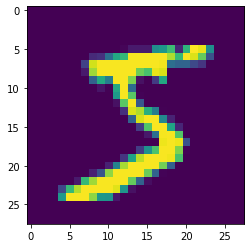

In [75]:
from matplotlib import pyplot as plt
plt.imshow(x_train[0].reshape(28,28))

In [51]:
x_train.shape

(60000, 784)